Deutsch-Jozsa with Qiskit

In [4]:
from qiskit import __version__
 
print(__version__)

2.3.0


In [3]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
import numpy as np

To implement the Deutsch-Jozsa algorithm in Qiskit, we'll start by defining a function dj_query that generates a quantum circuit implementing a query gate, for a randomly selected function satisfying the promise for the Deutsch-Jozsa problem. With a 50% chance, the function is constant, and with 50% change the function is balanced. For each of those two possibilities, the function is selected uniformly from the functions of that type. The argument is the number of input bits of the function.

In [1]:
def dj_query(num_qubits):
    # Create a circuit implementing for a query gate for a random function
    # satisfying the promise for the Deutsch-Jozsa problem.
 
    qc = QuantumCircuit(num_qubits + 1)
 
    if np.random.randint(0, 2):
        # Flip output qubit with 50% chance
        qc.x(num_qubits)
    if np.random.randint(0, 2):
        # return constant circuit with 50% chance
        return qc
 
    # Choose half the possible input strings
    on_states = np.random.choice(
        range(2**num_qubits),  # numbers to sample from
        2**num_qubits // 2,  # number of samples
        replace=False,  # makes sure states are only sampled once
    )
 
    def add_cx(qc, bit_string):
        for qubit, bit in enumerate(reversed(bit_string)):
            if bit == "1":
                qc.x(qubit)
        return qc
 
    for state in on_states:
        qc.barrier()  # Barriers are added to help visualize how the functions are created.
        qc = add_cx(qc, f"{state:0b}")
        qc.mcx(list(range(num_qubits)), num_qubits)
        qc = add_cx(qc, f"{state:0b}")
 
    qc.barrier()
 
    return qc

We can show the quantum circuit implementation of the query gate using the draw method.

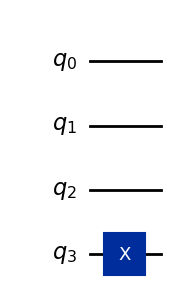

In [5]:
display(dj_query(3).draw(output="mpl"))

Next we define a function that creates the Deutsch-Jozsa circuit, taking a quantum circuit implementation of a query gate as an argument.

In [6]:
def compile_circuit(function: QuantumCircuit):
    # Compiles a circuit for use in the Deutsch-Jozsa algorithm.
 
    n = function.num_qubits - 1
    qc = QuantumCircuit(n + 1, n)
    qc.x(n)
    qc.h(range(n + 1))
    qc.compose(function, inplace=True)
    qc.h(range(n))
    qc.measure(range(n), range(n))
    return qc

Finally, a function that runs the Deutsch-Jozsa circuit once is defined.

In [7]:
def dj_algorithm(function: QuantumCircuit):
    # Determine if a function is constant or balanced.
 
    qc = compile_circuit(function)
 
    result = AerSimulator().run(qc, shots=1, memory=True).result()
    measurements = result.get_memory()
    if "1" in measurements[0]:
        return "balanced"
    return "constant"

We can test our implementation by choosing a function randomly, displaying the quantum circuit implementation of a query gate for this function, and then running the Deutsch-Jozsa algorithm on that function.

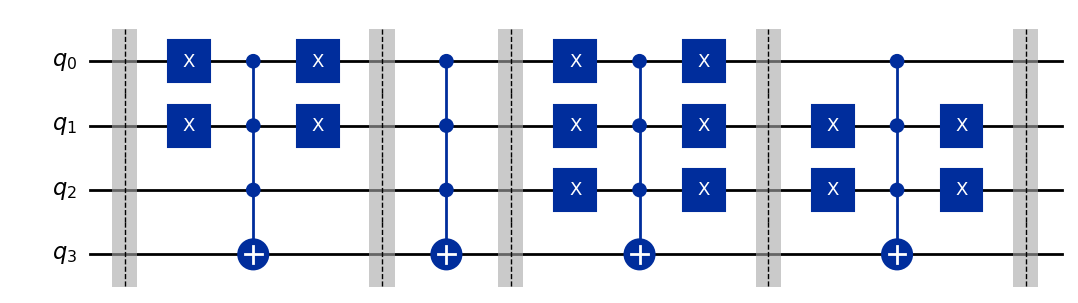

'balanced'

In [8]:
f = dj_query(3)
display(f.draw("mpl"))
display(dj_algorithm(f))

The Bernstein-Vazirani problem

While the Deutsch-Jozsa circuit solves the Bernstein-Vazirani problem with a single query, any classical query algorithm must make at least n queries to solve this problem.

This can be reasoned through a so-called information theoretic argument, which is very simple in this case. Each classical query reveals a single bit of information about the solution, and there are N bits of information that need to be uncovered — so at least n queries are needed.

It is, in fact, possible to solve the Bernstein-Vazirani problem classically by querying the function on each of the n strings having a single 1, in each possible position, and 0 for all other bits, which reveals the bits of s one at a time. Therefore, the advantage of quantum over classical algorithms for this problem is 1 query versus n queries.

Bernstein-Vazirani with Qiskit

We've already implemented the Deutsch-Jozsa circuit above, and here we will make use of it to solve the Bernstein-Vazirani problem. First we'll define a function that implements a query gate for the Bernstein-Vazirani problem given any binary strinG S.

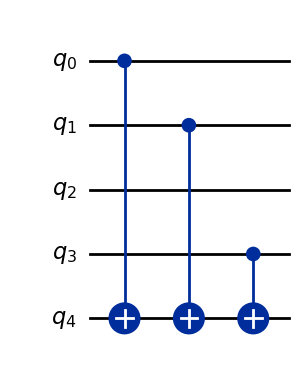

In [9]:
def bv_query(s):
    # Create a quantum circuit implementing a query gate for the
    # Bernstein-Vazirani problem.
 
    qc = QuantumCircuit(len(s) + 1)
    for index, bit in enumerate(reversed(s)):
        if bit == "1":
            qc.cx(index, len(s))
    return qc
 
 
display(bv_query("1011").draw(output="mpl"))

Now we can create a function that runs the Deutsch-Jozsa circuit on the function, using the compile_circuit function that was defined previously.

In [10]:
def bv_algorithm(function: QuantumCircuit):
    qc = compile_circuit(function)
    result = AerSimulator().run(qc, shots=1, memory=True).result()
    return result.get_memory()[0]
 
 
display(bv_algorithm(bv_query("1011")))

'1011'

In the context of the Bernstein-Vazirani problem, it is common that the Deutsch-Jozsa algorithm is referred to as the "Bernstein-Vazirani algorithm." This is slightly misleading, because the algorithm is the Deutsch-Jozsa algorithm, as Bernstein and Vazirani were very clear about in their work.

What Bernstein and Vazirani did after showing that the Deutsch-Jozsa algorithm solves the Bernstein-Vazirani problem (as it is stated above) was to define a much more complicated problem, known as the recursive Fourier sampling problem. This is a highly contrived problem where solutions to different instances of the problem effectively unlock new levels of the problem arranged in a tree-like structure. The Bernstein-Vazirani problem is essentially just the base case of this more complicated problem.

The recursive Fourier sampling problem was the first known example of a query problem where quantum algorithms have a so-called super-polynomial advantage over probabilistic algorithms, thereby surpassing the advantage of quantum over classical offered by the Deutsch-Jozsa algorithm. Intuitively speaking, the recursive version of the problem amplifies the 1 versus N advantage of quantum algorithms to something much larger.

The most challenging aspect of the mathematical analysis establishing this advantage is showing that classical query algorithms can't solve the problem without making lots of queries. This is quite typical; for many problems it can be very difficult to rule out creative classical approaches that solve them efficiently.

Simon's problem, and the algorithm for it described in the next section, does provide a much simpler example of a super-polynomial (and, in fact, exponential) advantage of quantum over classical algorithms, and for this reason the recursive Fourier sampling problem is less often discussed. It is, nevertheless, an interesting computational problem in its own right.